## Goal 

Use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. <br>
<br>
Specifically, build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales. <br>
<br>
READ : <br>
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this. <br>
<br>
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 

The **training data**, comprising time series of features store_nbr, family, and onpromotion as well as the target sales : <br>
<br>
- **store_nbr** identifies the store at which the products are sold <br>
<br>
- **family** identifies the type of product sold <br>
<br>
- **sales** gives the total sales for a product family at a particular store at a given date <br>
Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). <br>
<br>
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date. <br>
<br>
<br>
Test csv looks like train csv. <br>
Target : predict '**sales**' in the test csv. <br>
The dates in the test data are for the 15 days after the last date in the training data.

In [23]:
df_train = pd.read_csv('/Users/augustincablant/Desktop/kaggle/train.csv')
df_test = pd.read_csv('datasets/test.csv')
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


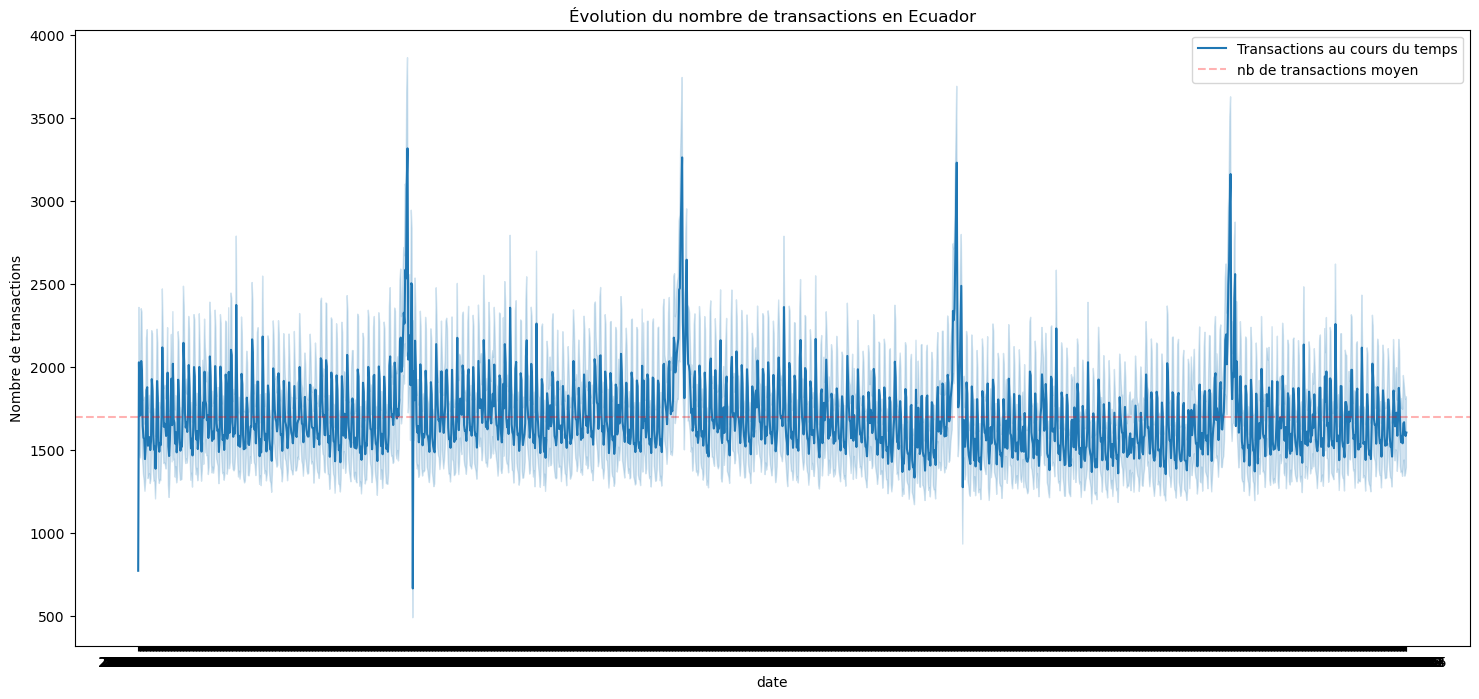

In [48]:
transaction = pd.read_csv('/Users/augustincablant/Desktop/kaggle/transactions.csv')


plt.figure(figsize=(18, 8))
sns.lineplot(x= 'date', y= 'transactions', data=transaction, label='Transactions au cours du temps')
plt.axhline(transaction['transactions'].mean(), color='red', linestyle='--', alpha=0.3,label='nb de transactions moyen')
plt.xlabel('date')
plt.ylabel('Nombre de transactions')
plt.title('Évolution du nombre de transactions en Ecuador')
plt.legend()
plt.show()

Store metadata, including city, state, type, and cluster <br>
<br>
cluster is a grouping of similar stores.

In [5]:
store = pd.read_csv('datasets/stores.csv')
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

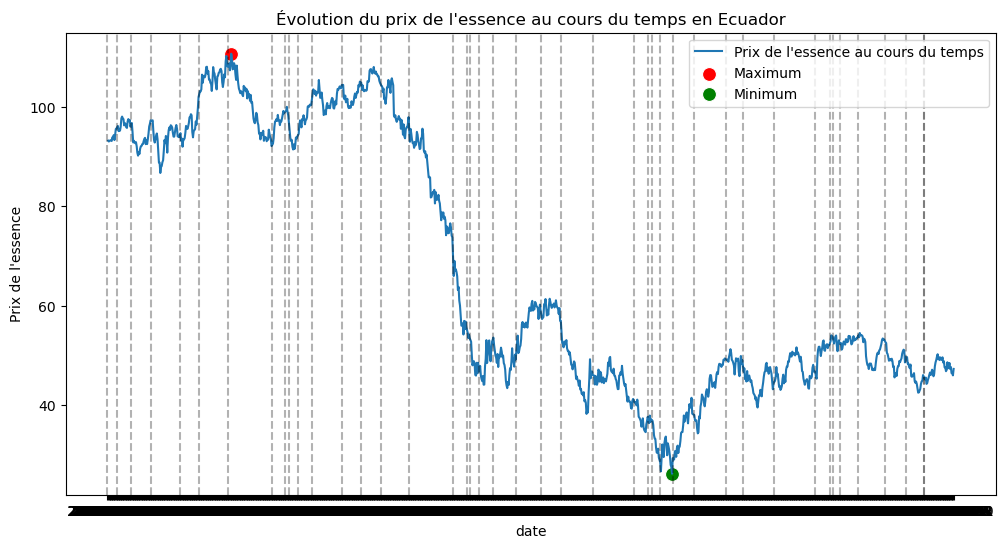

In [42]:
oil = pd.read_csv('datasets/oil.csv')
plt.figure(figsize=(12, 6))
sns.lineplot(x= 'date', y= 'dcoilwtico', data=oil, label='Prix de l\'essence au cours du temps')

# max and min
max_points = oil[oil['dcoilwtico'] == oil['dcoilwtico'].max()]
min_points = oil[oil['dcoilwtico'] == oil['dcoilwtico'].min()]

sns.scatterplot(x=max_points['date'], y=max_points['dcoilwtico'], color='red', label='Maximum', s=100 )
sns.scatterplot(x=min_points['date'], y=min_points['dcoilwtico'], color='green', label='Minimum', s=100)

# Marquer les moments de rupture en bleu
moments_rupture = list(oil[oil['dcoilwtico'].isnull()]['date'])
rupture_prices = oil[oil['date'].isin(moments_rupture)]
#sns.scatterplot(x=rupture_prices['date'], y=rupture_prices['dcoilwtico'], color='black', label='Moments de rupture',s=0.5)

for moment_date in moments_rupture:
    plt.axvline(moment_date, color='black', linestyle='--', alpha=0.3)


plt.xlabel('date')
plt.ylabel('Prix de l\'essence')
plt.title('Évolution du prix de l\'essence au cours du temps en Ecuador')
plt.legend()


plt.show()

In [25]:
oil.head(15)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27
